## Demonstrating the TimeComponent Class
This section demonstrates how to use the `TimeComponent` class directly for defining and manipulating time structures in energy system scenarios. For each model, OSeMOSYS and PyPSA, we will show two different setups: a uniform time structure and a more complex, non-uniform structure.

### 1. Import and Setup
First, import the class and set up a clean output directory for the demonstration.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.pardir)))

from pyoscomp.scenario.components.time import TimeComponent
from pyoscomp.scenario.visualization import TimeVisualizer

import shutil
# Set up a clean demo output directory
DEMO_DIR = "demo_output/time_component"
if os.path.exists(DEMO_DIR):
    shutil.rmtree(DEMO_DIR)
os.makedirs(DEMO_DIR, exist_ok=True)

### 2. OSeMOSYS Setup
OSeMOSYS represents time in aggregated timeslices, which are unique combinations of seasons, day types, and daily time brackets.

#### 2.1. Uniform Time Structure Example
We can create simple, uniform time structure with 3 years, 2 seasons, 2 day types, and 2 daily time brackets.

In [2]:
# --- Uniform Time Structure ---
uniform_dir = os.path.join(DEMO_DIR, "uniform")
os.makedirs(uniform_dir, exist_ok=True)

# Define time structure parameters
years = (2025, 2050, 5)  # start, end, step
seasons = {"Winter": 182, "Summer": 183}  # 365 days total
daytypes = {"Weekday": 5, "Weekend": 2}
brackets = {"Day": 12, "Night": 12}  # 24 hours total

# Create and configure the TimeComponent
time_uniform = TimeComponent(uniform_dir)
time_uniform.add_time_structure(years, seasons, daytypes, brackets)
time_uniform.save()  # Save to CSV

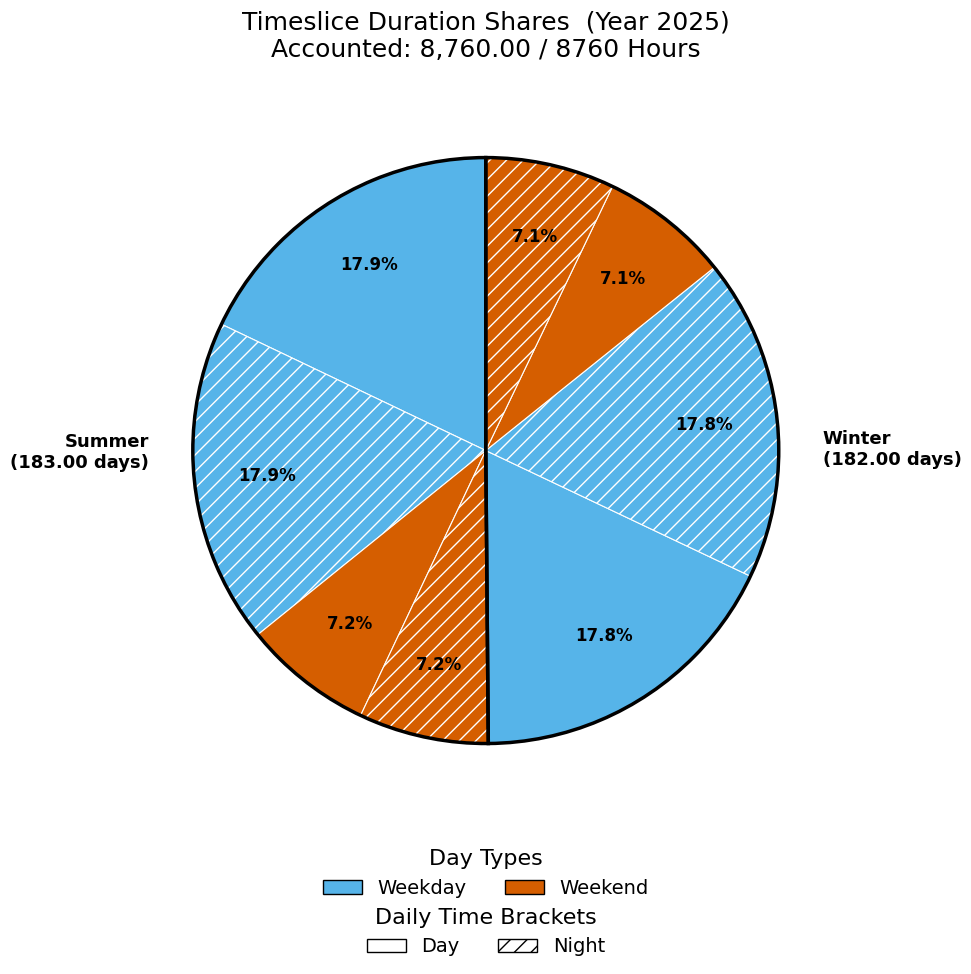

In [3]:
# Visualize the uniform scenario
time_uniform = TimeComponent(uniform_dir)  # Load from CSV
time_uniform.load()

viz = TimeVisualizer(time_uniform)
fig, ax = viz.plot_duration_pie(year = 2025)

#### 2.2. Complex (Non-Uniform) Time Structure Example
Now, let's create a more complex time structure with irregular season lengths, custom day types, and non-uniform daily brackets.

In [4]:
# --- Complex Time Structure ---
complex_dir = os.path.join(DEMO_DIR, "complex")
os.makedirs(complex_dir, exist_ok=True)

# Define time structure parameters
years_complex = (2025, 2055, 5)  # 2025, 2030, 2035
seasons_complex = {"Winter": 90, "Summer": 90, "Shoulder": 185}
daytypes_complex = {"Normal": 0.9, "Peak": 0.09, "SuperPeak": 0.01}
brackets_complex = {"Base": 18, "Ramp": 4, "PeakHour": 1.9, "CriticalHour": 0.1}

# Create and configure the TimeComponent
time_complex = TimeComponent(complex_dir)
time_complex.add_time_structure(years_complex, seasons_complex, daytypes_complex, brackets_complex)
time_complex.save()

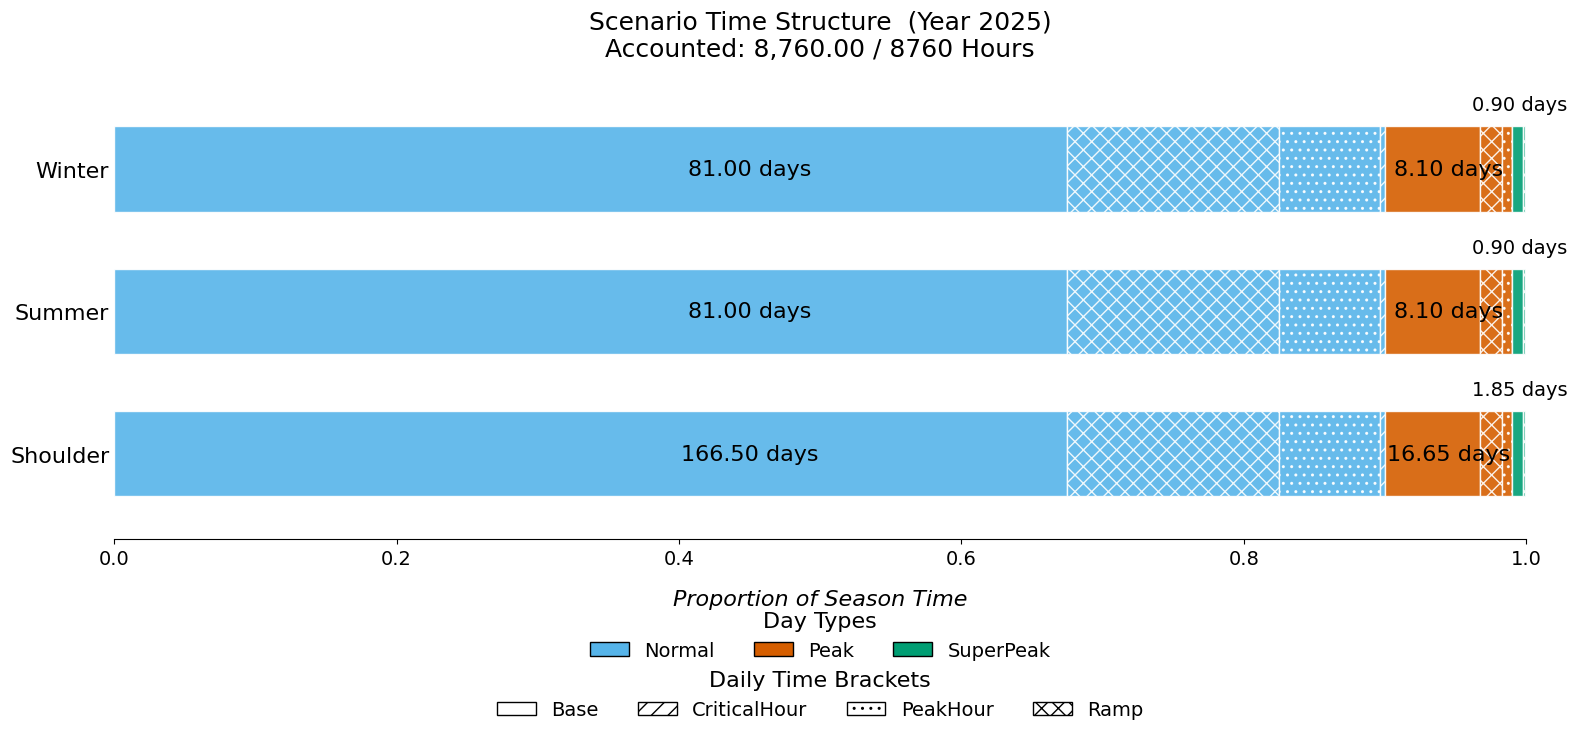

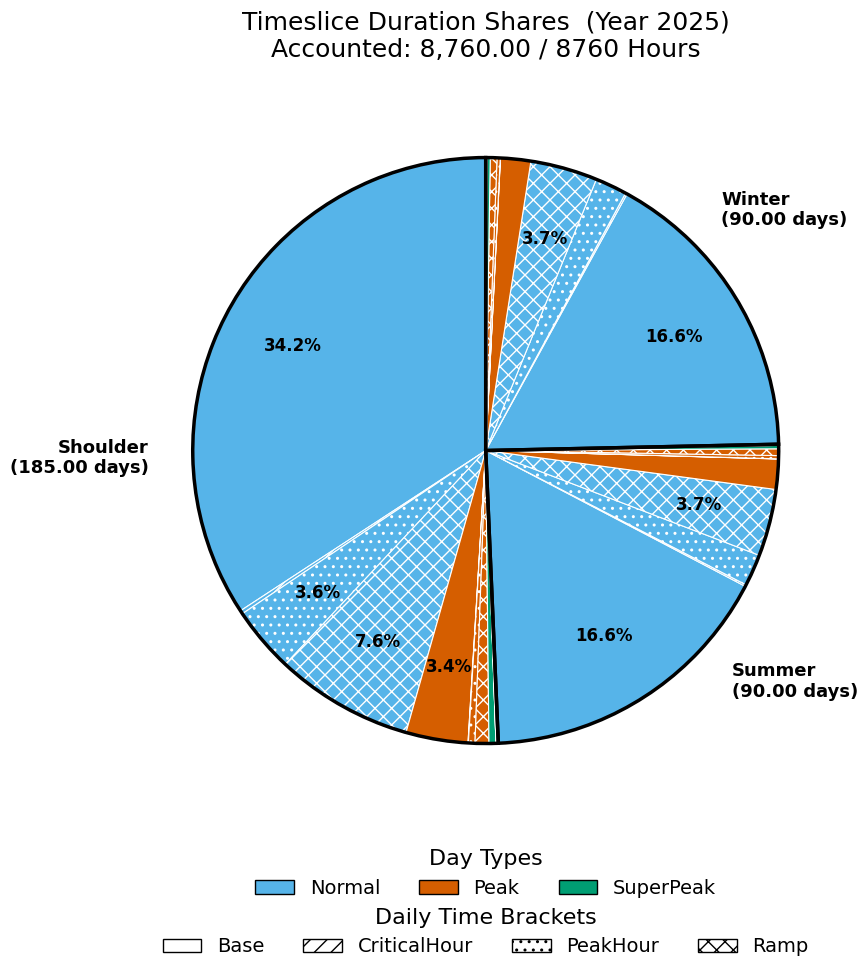

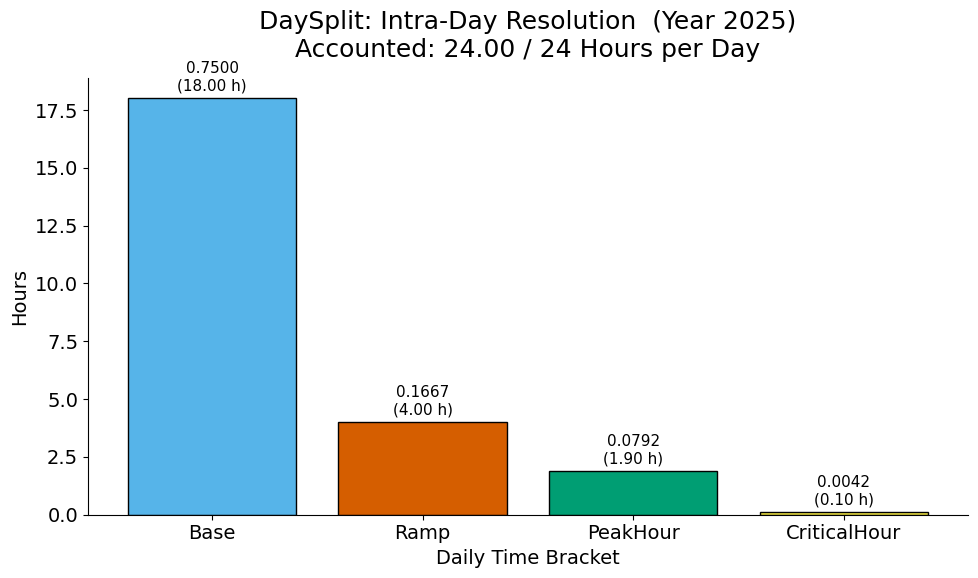

In [5]:
# Visualize the complex scenario
time_complex = TimeComponent(complex_dir)  # Load from CSV
time_complex.load()

viz = TimeVisualizer(time_complex)
viz.show()
fig, ax = viz.plot_duration_pie(year = 2025)  # alternative view
fig, ax = viz.plot_daysplit_bar(year = 2025)

### 3. PyPSA Setup
PyPSA represents time as sequential **snapshots** — datetime-indexed rows that the optimizer iterates over. Each snapshot has a **weighting** (duration in hours) that tells the solver how many real hours that timestep represents. When modelling long-horizon capacity expansion, snapshots are paired with **investment periods** (years) via a `pd.MultiIndex`.

#### 3.1. Uniform Time Structure Example
The simplest setup: hourly (or N-hourly) timesteps repeated for every investment period.

In [6]:
import pypsa
import pandas as pd

timesteps = pd.date_range("2025-01-01", "2030-12-31 23:59", freq="1d")

n_uniform = pypsa.Network()
n_uniform.set_snapshots(timesteps)

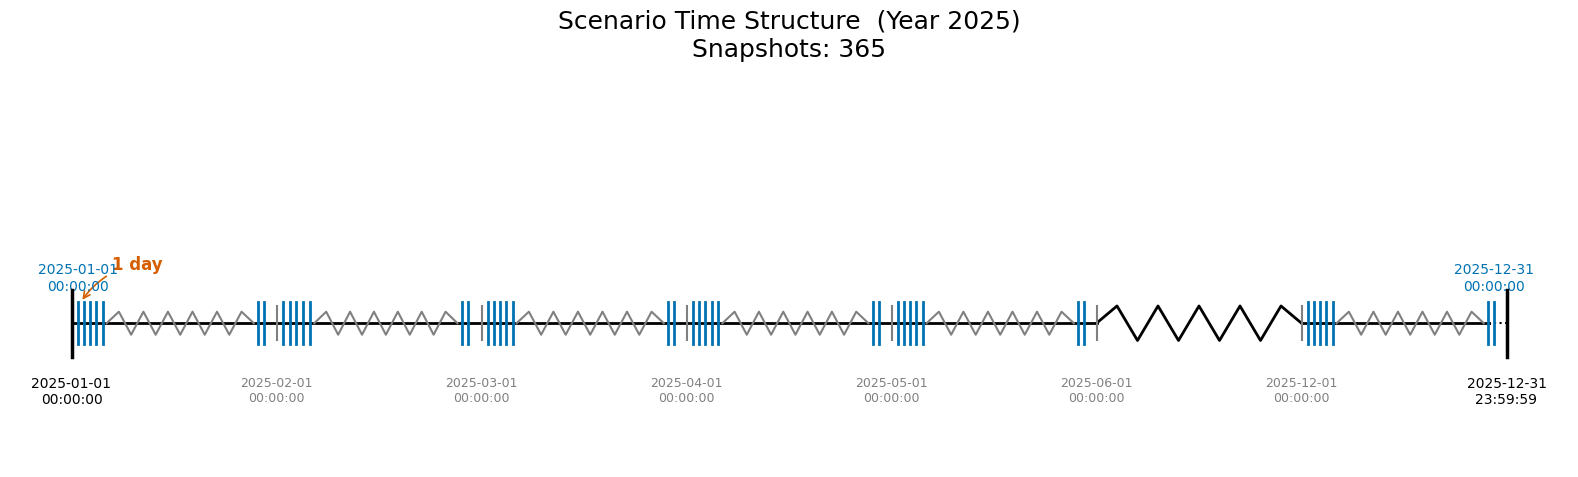

In [7]:
# Visualize the uniform PyPSA network snapshots
viz = TimeVisualizer(n_uniform)
fig, ax = viz.plot_snapshot_timeline(year=2025)

#### 3.2. Complex (Non-Uniform) Time Structure Example
Real studies rarely run all 8760 hours. A common technique is **representative snapshots**: pick a handful of timesteps 

In [8]:
from datetime import datetime, timedelta
import numpy as np

np.random.seed(42)  # For reproducibility

years = [2025, 2030, 2035]

start = datetime(2025, 1, 1, 0, 0, 0)
current = start
timesteps = [current]

# Defin possible random jumps
hours_jumps = [12]
days_jumps = [0, 3, 7, 14]

while True:
    h = int(np.random.choice(hours_jumps))
    d = int(np.random.choice(days_jumps))
    current = current + timedelta(days=d, hours=h)
    if current.year > years[-1]:
        break
    timesteps.append(current)

n_complex = pypsa.Network()
n_complex.set_snapshots(timesteps)

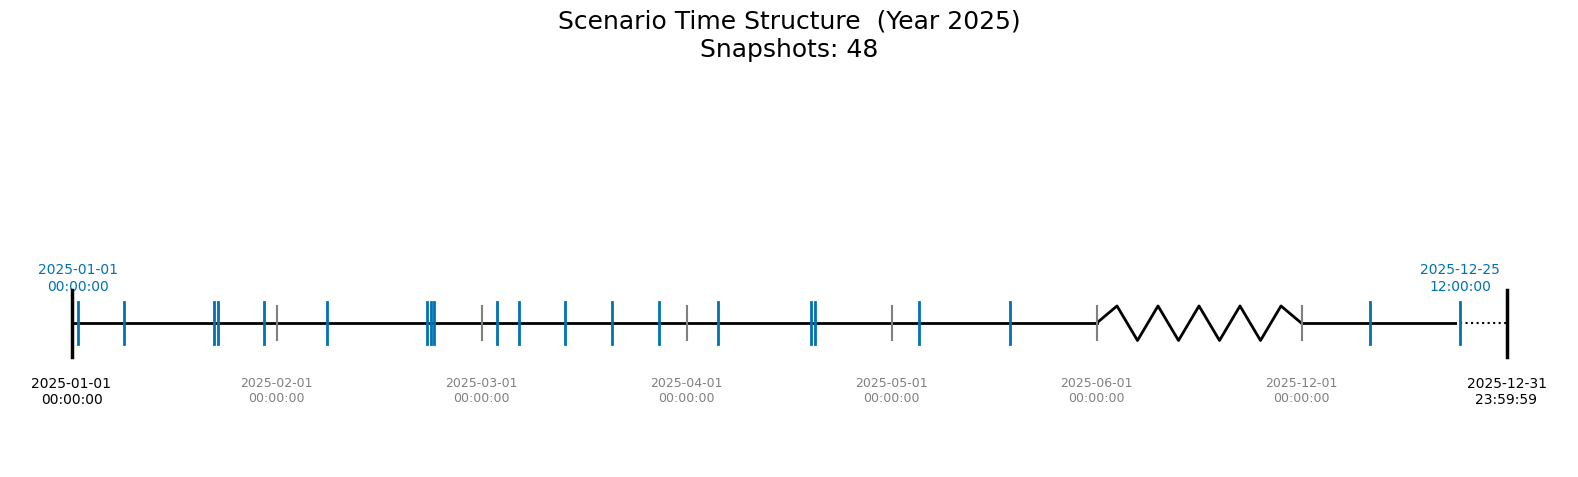

In [9]:
# Visualize the complex PyPSA network snapshots
viz = TimeVisualizer(n_complex)
viz.show(year = 2025)

### 4. Translating between Models
The `pyoscomp.translation` module bridges the two paradigms:
- **OSeMOSYS → PyPSA** (`to_snapshots`): converts hierarchical timeslices + YearSplit fractions into a `pd.MultiIndex` of snapshots with hour-weighted `snapshot_weightings`.
- **PyPSA → OSeMOSYS** (`to_timeslices`): decomposes datetime snapshots into Seasons, DayTypes, DailyTimeBrackets, and Timeslices with validated YearSplit.

#### 4.1. OSeMOSYS → PyPSA
We reuse the complex OSeMOSYS scenario from Section 2.2. The `ScenarioData` interface bundles all CSV files into a frozen container that translators consume.

In [10]:
from pyoscomp.interfaces import ScenarioData
from pyoscomp.translation.time.translate import to_snapshots
import pandas as pd

# ScenarioData.from_directory() requires REGION.csv and TECHNOLOGY.csv,
# TimeComponent only produces time-related CSVs.
# Write minimal stubs so the loader can construct the full container.
for stub in ["REGION", "TECHNOLOGY"]:
    pd.DataFrame({"VALUE": [stub]}).to_csv(
        os.path.join(complex_dir, f"{stub}.csv"), index=False
    )

# Build frozen data container from the complex scenario CSVs
data = ScenarioData.from_directory(complex_dir, validate=False)

# Convert OSeMOSYS timeslices → PyPSA snapshots
snap_result = to_snapshots(data)
print(f"Valid: {snap_result.validate_coverage()}")
print(f"Years: {snap_result.years}")
print(f"Timeslice labels: {snap_result.timeslice_names[:5]} …")
print(f"\nSnapshot weightings (hours per timeslice-period):")
print(snap_result.weightings.head(10))

Valid: True
Years: [2025, 2030, 2035, 2040, 2045, 2050, 2055]
Timeslice labels: ['Shoulder_Normal_Base', 'Shoulder_Normal_CriticalHour', 'Shoulder_Normal_PeakHour', 'Shoulder_Normal_Ramp', 'Shoulder_Peak_Base'] …

Snapshot weightings (hours per timeslice-period):
period  timestep                       
2025    Shoulder_Normal_Base               2997.000
        Shoulder_Normal_CriticalHour         16.650
        Shoulder_Normal_PeakHour            316.350
        Shoulder_Normal_Ramp                666.000
        Shoulder_Peak_Base                  299.700
        Shoulder_Peak_CriticalHour            1.665
        Shoulder_Peak_PeakHour               31.635
        Shoulder_Peak_Ramp                   66.600
        Shoulder_SuperPeak_Base              33.300
        Shoulder_SuperPeak_CriticalHour       0.185
dtype: float64


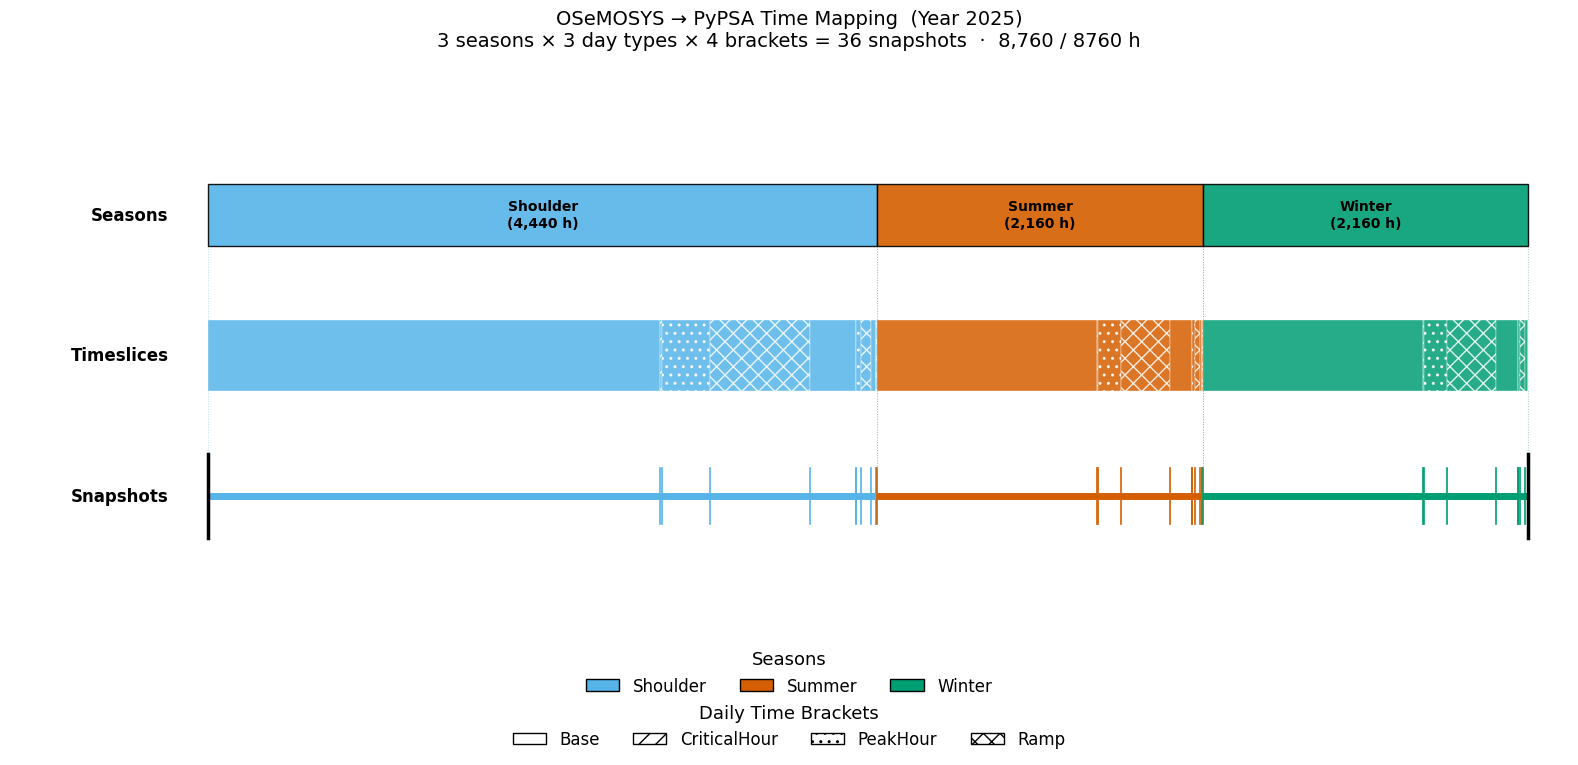

In [11]:
# Visualize the timeslice → snapshot mapping
viz = TimeVisualizer(time_complex)
fig, ax = viz.plot_timeslice_snapshot_map(snap_result, year=2025)

#### 4.2. PyPSA → OSeMOSYS
The inverse direction takes sequential datetime snapshots and decomposes them into hierarchical timeslices. The algorithm:
1. Extracts unique **dates** → creates `DayType` day-of-year ranges
2. Extracts unique **times** → creates `DailyTimeBracket` time-of-day ranges
3. Forms the Cartesian product → `Timeslice` objects
4. Validates that timeslices partition each year completely (8760 / 8784 hours)

In [12]:
from pyoscomp.translation.time.translate import to_timeslices

# Extract the timestep level from the MultiIndex (to_timeslices expects DatetimeIndex)
ts_result = to_timeslices(n_complex.snapshots)

print(f"Valid: {ts_result.validate_coverage()}")
print(f"Years: {ts_result.years}")
print(f"DayTypes: {len(ts_result.daytypes)}")
print(f"DailyTimeBrackets: {len(ts_result.dailytimebrackets)}")
print(f"Timeslices: {len(ts_result.timeslices)}")

# Export OSeMOSYS-compatible CSVs
csv_dict = ts_result.export()
print(f"\nExported files: {list(csv_dict.keys())}")
print(f"\nYearSplit sample (first 5 rows):")
print(csv_dict["YearSplit"].head())

Valid: True
Years: [2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035]
DayTypes: 351
DailyTimeBrackets: 2
Timeslices: 702

Exported files: ['YEAR', 'SEASON', 'DAYTYPE', 'DAILYTIMEBRACKET', 'TIMESLICE', 'YearSplit', 'DaySplit']

YearSplit sample (first 5 rows):
                      TIMESLICE  YEAR    VALUE
0   X_01-01 to 01-01_T0000_1200  2025  0.00137
1  X_01-01 to 01-01_T1200_24:00  2025  0.00137
2   X_01-02 to 01-02_T0000_1200  2025  0.00137
3  X_01-02 to 01-02_T1200_24:00  2025  0.00137
4   X_01-03 to 01-03_T0000_1200  2025  0.00137


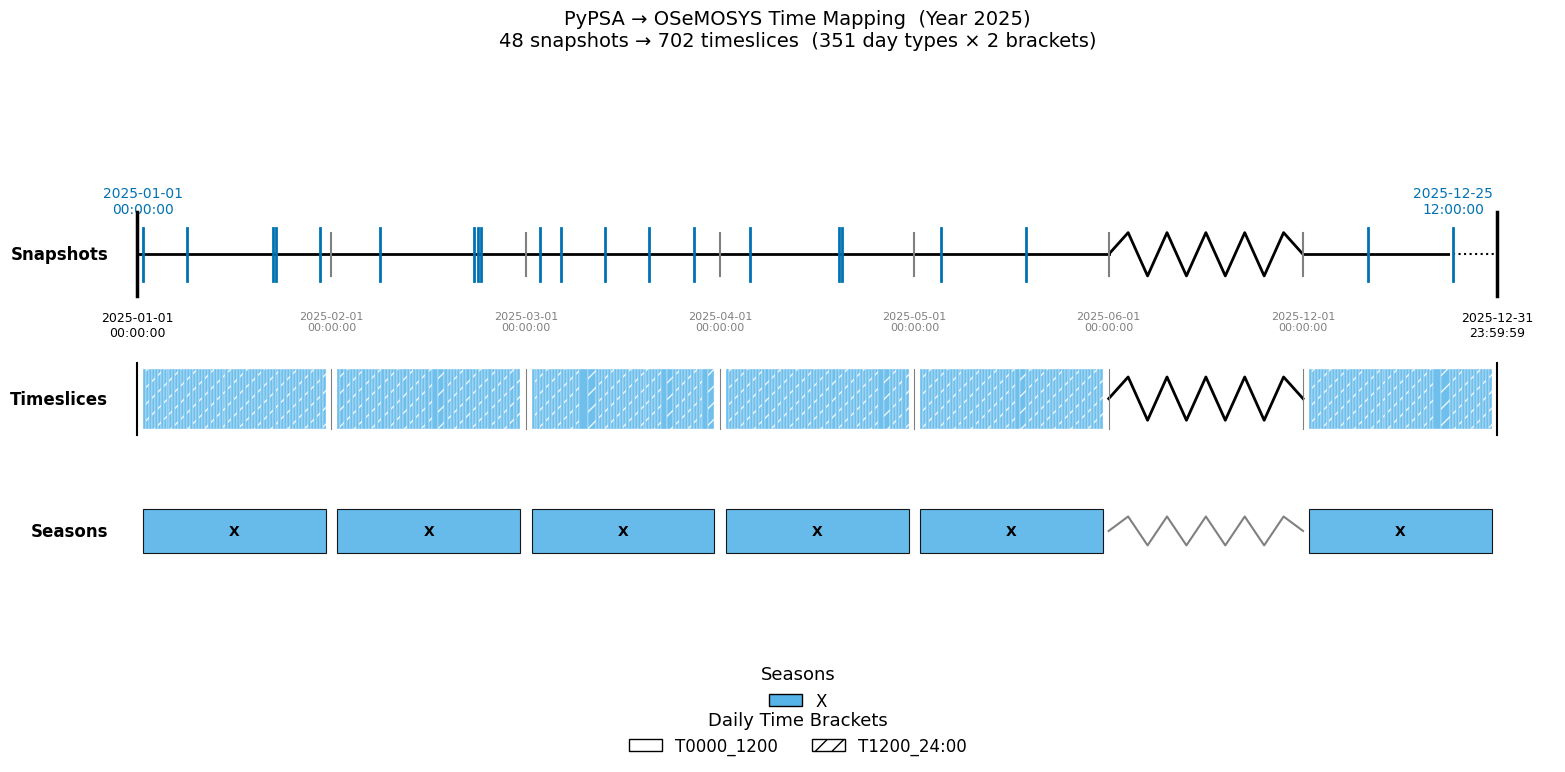

In [13]:
# Visualize the snapshot → timeslice mapping
viz = TimeVisualizer(time_complex)
fig, ax = viz.plot_snapshot_timeslice_map(ts_result, year=2025)